# Prerequisites

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git#egg=tensorflow-examples[model_maker]

In [ ]:
import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader
from tensorflow_examples.lite.model_maker.core.task import image_classifier
from tensorflow_examples.lite.model_maker.core.task.configs import QuantizationConfig
from tensorflow_examples.lite.model_maker.core.task.model_spec import mobilenet_v2_spec
from tensorflow_examples.lite.model_maker.core.task.model_spec import ImageModelSpec
from tensorflow_examples.lite.model_maker.core.task import model_spec as ms

import matplotlib.pyplot as plt

import os
import imghdr
import shutil

# Data Download

In [ ]:
# 드라이브 마운트시켜주기
# 런타임 유형 반드시 GPU!!

In [ ]:
# 압축 풀어주기
base_dir = "/content/drive/My Drive/dataset/cropsdoctor"

os.chdir(base_dir)
# !unzip cropsdoctor.zip

# Data Preprocessing

In [ ]:
# 만약 .ipynb_checkpoint 디렉터리가 생성되면 지워주기
# cropsdoctor.zip 파일 지워주기

# !rm -rf `find -type d -name .ipynb_checkpoints`
# os.remove(os.path.join(base_dir, 'cropsdoctor.zip'))

In [ ]:
# train 디렉터리 지정해주기
train_dir = base_dir

In [ ]:
# tensorflow lite에서 지원하지 않는 포맷 제거하기
# formats = ['jpg', 'jpeg', 'png', 'gif', 'bng']

# for dir in os.listdir(train_dir):
#   for file in os.listdir(os.path.join(base_dir, train_dir, dir)):
#     if imghdr.what(os.path.join(base_dir, train_dir, dir, file)) not in formats:
#       os.remove(os.path.join(base_dir, train_dir, dir, file))

In [ ]:
# train, test별로, 범주별로 이미지 개수 확인
# 총 학습 이미지 수 확인

train_cnt = 0
cropdict = {}

print('------------------------병해 당 이미지의 개수---------------------------')
for dir in os.listdir(train_dir):
  cropname = dir.split('_')[0]
  if cropname in cropdict:
    cropdict[cropname] += 1
  else:
    cropdict[cropname] = 1

  train_cnt += len(os.listdir(os.path.join(train_dir, dir)))
  print(f'[{dir}] : {len(os.listdir(os.path.join(train_dir, dir)))}')
print()

print('------------------------작물 당 병해의 수---------------------------')
for crop in cropdict.keys():
  print(f'[{crop}] : {cropdict[crop]}')
print()

print('------------------------전반적인 정보---------------------------')
print(f'총 병해 수 : {len(os.listdir(train_dir))}')
print(f'총 학습 이미지 : {train_cnt}')

------------------------병해 당 이미지의 개수---------------------------
[고추_건강] : 1000
[고추_모자이크병] : 1000
[고추_세균점무늬병] : 1000
[고추_흰가루병] : 1000
[옥수수_건강] : 1000
[옥수수_검은줄오갈병] : 1000
[옥수수_깜부기병] : 1000
[옥수수_깨씨무늬병] : 996
[옥수수_잎집무늬마름병] : 1000
[콩_건강] : 1000
[콩_균핵병] : 1000
[콩_노균병] : 1000
[콩_미이라병] : 953
[콩_불마름병] : 1000
[콩_자주무늬병] : 965
[콩_점무늬병] : 1000
[콩_콩황화모틀모자이크바이러스] : 1000
[콩_탄저병] : 1000
[토마토_건강] : 999
[토마토_겹무늬병] : 1000
[토마토_모자이크병] : 1000
[토마토_세균점무늬병] : 1000
[토마토_잎곰팡이] : 1000
[토마토_잎마름역병] : 999
[토마토_점박이응애] : 1000
[토마토_탄저병] : 1000
[토마토_황화잎말림바이러스] : 1000
[토마토_흰무늬병] : 1000
[감자_건강] : 1000
[감자_겹둥근무늬병] : 1000
[감자_역병] : 1000
[감자_잎마름병] : 1000
[감자_줄기검은병] : 1000
[고추_갈색점무늬병] : 1000

-----

# Visualization

In [ ]:
# 시각화를 위한 이미지 및 레이블 저장
# idx번째 이미지 불러오기
idx = 237
img_list = []

for dir in os.listdir(train_dir):
  img = os.listdir(os.path.join(train_dir, dir))[idx]
  img_list.append(os.path.join(train_dir, dir, img))

labels = [dir for dir in os.listdir(train_dir)]

print(labels)
print(img_list)

['고추_건강', '고추_모자이크병', '고추_세균점무늬병', '고추_흰가루병', '옥수수_건강', '옥수수_검은줄오갈병', '옥수수_깜부기병', '옥수수_깨씨무늬병', '옥수수_잎집무늬마름병', '콩_건강', '콩_균핵병', '콩_노균병', '콩_미이라병', '콩_불마름병', '콩_자주무늬병', '콩_점무늬병', '콩_콩황화모틀모자이크바이러스', '콩_탄저병', '토마토_건강', '토마토_겹무늬병', '토마토_모자이크병', '토마토_세균점무늬병', '토마토_잎곰팡이', '토마토_잎마름역병', '토마토_점박이응애', '토마토_탄저병', '토마토_황화잎말림바이러스', '토마토_흰무늬병', '감자_건강', '감자_겹둥근무늬병', '감자_역병', '감자_잎마름병', '감자_줄기검은병', '고추_갈색점무늬병']
['/content/drive/My Drive/dataset/cropsdoctor/고추_건강/5f11a48a-467f-4639-adcb-f7189c669a5f___JR_HL 8348.JPG', '/content/drive/My Drive/dataset/cropsdoctor/고추_모자이크병/_0_5226.jpeg', '/content/drive/My Drive/dataset/cropsdoctor/고추_세균점무늬병/9caf62cb-38

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4366 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4453 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4523 missing from current font.
  font.set_text(s

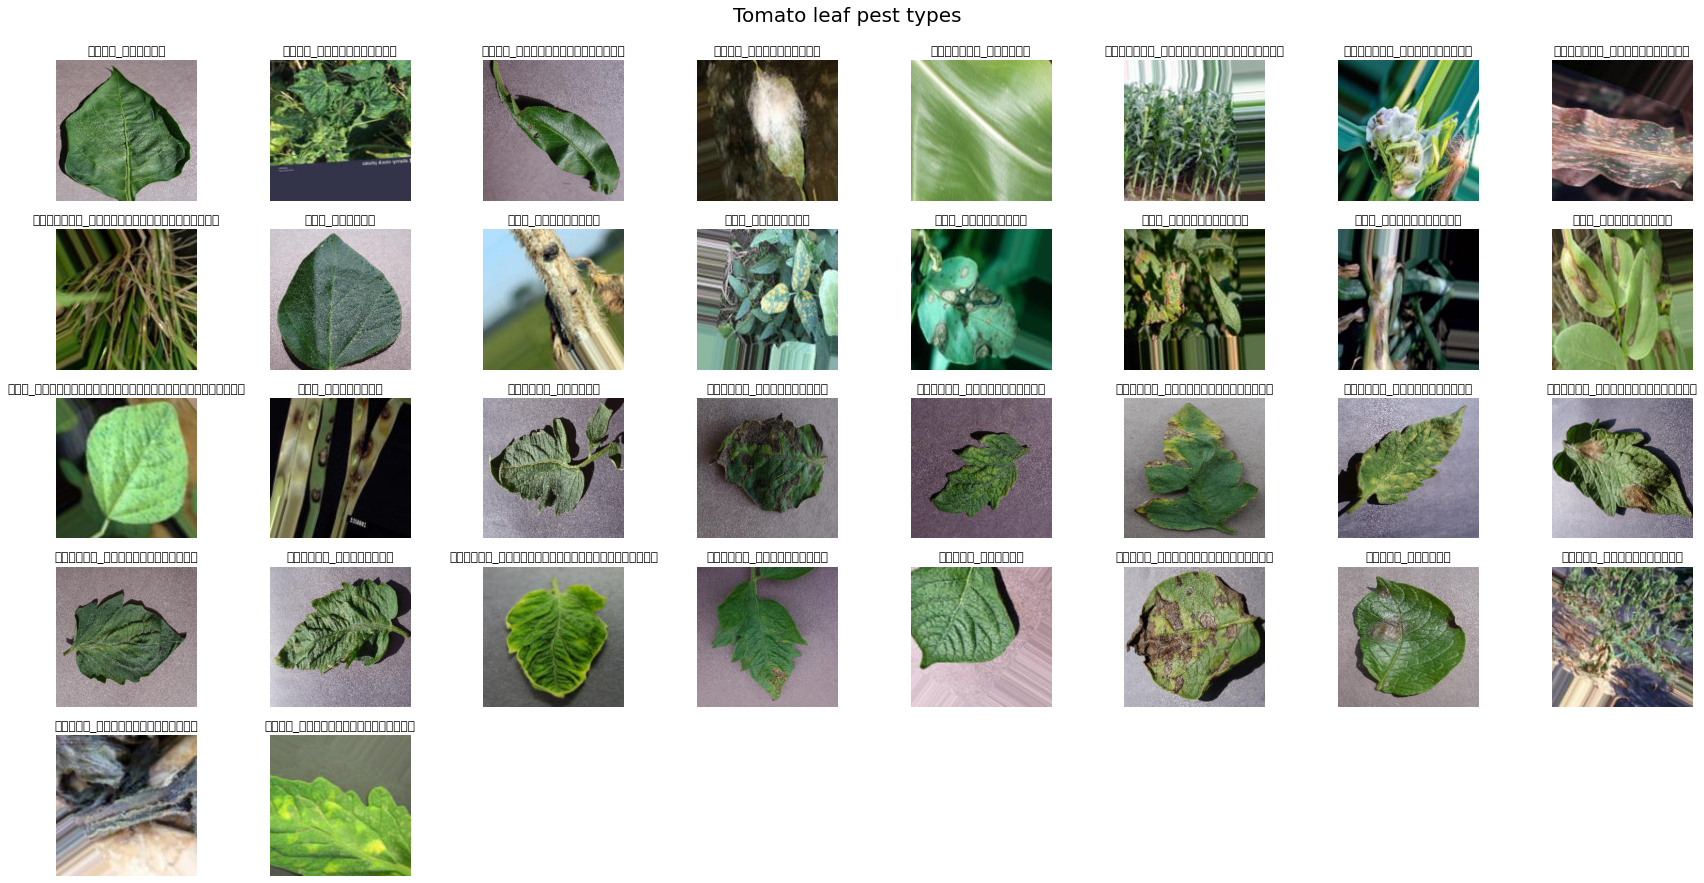

In [ ]:
# 데이터셋 시각화

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

plt.figure(figsize=(30, 15))
for i, img_path in enumerate(img_list):
  sp = plt.subplot(5, 8, i + 1)
  sp.axis('Off') 
    
  img = mpimg.imread(img_path)
  sp.set_title(f'{labels[i]}', fontsize=12)
  plt.imshow(img)

plt.suptitle('Tomato leaf pest types', fontsize=20, y=0.93)
# plt.subplots_adjust(wspace=0.3, hspace=-0.4)
plt.show()

# Train Test Split

In [ ]:
# 학습에 90% 사용, 테스트에 10% 사용
split_ratio = 0.9

data = ImageClassifierDataLoader.from_folder(train_dir)
train_data, test_data = data.split(split_ratio)

INFO:tensorflow:Load image with size: 33912, num_label: 34, labels: 감자_건강, 감자_겹둥근무늬병, 감자_역병, 감자_잎마름병, 감자_줄기검은병, 고추_갈색점무늬병, 고추_건강, 고추_모자이크병, 고추_세균점무늬병, 고추_흰가루병, 옥수수_건강, 옥수수_검은줄오갈병, 옥수수_깜부기병, 옥수수_깨씨무늬병, 옥수수_잎집무늬마름병, 콩_건강, 콩_균핵병, 콩_노균병, 콩_미이라병, 콩_불마름병, 콩_자주무늬병, 콩_점무늬병, 콩_콩황화모틀모자이크바이러스, 콩_탄저병, 토마토_건강, 토마토_겹무늬병, 토마토_모자이크병, 토마토_세균점무늬병, 토마토_잎곰팡이, 토마토_잎마름역병, 토마토_점박이응애, 토마토_탄저병, 토마토_황화잎말림바이러스, 토마토_흰무늬병.


INFO:tensorflow:Load image with size: 33912, num_label: 34, labels: 감자_건강, 감자_겹둥근무늬병, 감자_역병, 감자_잎마름병, 감자_줄기검은병, 고추_갈색점무늬병, 고추_건강, 고추_모자이크병, 고추_세균점무늬병, 고추_흰가루병, 옥수수_건강, 옥수수_검은줄오갈병, 옥수수_깜부기병, 옥수수_깨씨무늬병, 옥수수_잎집무늬마름병, 콩_건강, 콩_균핵병, 콩_노균병, 콩_미이라병, 콩_불마름병, 콩_자주무늬병, 콩_점무늬병, 콩_콩황화모틀모자이크바이러스, 콩_탄저병, 토마토_건강, 토마토_겹무늬병, 토마토_모자이크병, 토마토_세균점무늬병, 토마토_잎곰팡이, 토마토_잎마름역병, 토마토_점박이응애, 토마토_탄저병, 토마토_황화잎말림바이러스, 토마토_흰무늬병.


# Train Model

In [ ]:
# 모델 학습시키기

model = image_classifier.create(train_data, epochs=50, 
                                model_spec=ms.efficientnet_lite0_spec, 
                                dropout_rate=0.2, learning_rate=0.005, 
                                use_augmentation=False)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2_7 (HubK (None, 1280)              3413024   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 34)                43554     
Total params: 3,456,578
Trainable params: 43,554
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/20
953/953 [==============================] - 100s 105ms/step - loss: 2.1249 - accuracy: 0.5098
Epoch 2/20
953/953 [==============================] - 99s 104ms/step - loss: 1.4057 - accuracy: 0.7658
Epoch 3/20
953/953 [==============================] - 97s 102ms/step - loss: 1.3209 - accuracy: 0.7971
Epoch 4/20
953/953 [==============================] - 

In [ ]:
# loss, accuracy 평가
loss, accuracy = model.evaluate(test_data)

106/106 [==============================] - 43s 408ms/step - loss: 1.0750 - accuracy: 0.8998


# Save Model

In [ ]:
# model.tflite 저장
model.export(export_dir='.')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/tmp7943ubkw/assets


INFO:tensorflow:Assets written to: /tmp/tmp7943ubkw/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmpvqw6tjul/labels.txt.


INFO:tensorflow:Saving labels in /tmp/tmpvqw6tjul/labels.txt.


In [ ]:
# label.txt 저장

labels = [dir for dir in os.listdir(train_dir)]

with open('labels.txt', 'w') as f:
  for label in labels:
    f.write(label)
    f.write('\n')